In [ ]:
import pandas as pd

# ✅ STEP 0: Load your full Spain dataset (with imputed values + weather + forecast_corr)
df = pd.read_csv("content/training_set_ES_with_weather.csv")

df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [ ]:
df.columns

Index(['DATETIME', 'VALUEMWHMETERINGDATA_customerES_1',
       'VALUEMWHMETERINGDATA_customerES_2',
       'VALUEMWHMETERINGDATA_customerES_5',
       'VALUEMWHMETERINGDATA_customerES_11',
       'VALUEMWHMETERINGDATA_customerES_19',
       'VALUEMWHMETERINGDATA_customerES_30',
       'VALUEMWHMETERINGDATA_customerES_31',
       'VALUEMWHMETERINGDATA_customerES_39',
       'VALUEMWHMETERINGDATA_customerES_40',
       ...
       'is_weekend', 'hour_of_day_category', 'total_consumption',
       '7day_rolling_avg', '7day_exp_rolling_avg', 'hourly_avg_30d',
       'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'cloudcover'],
      dtype='object', length=216)

In [ ]:
import pandas as pd

# ✅ STEP 0: Load your full Spain dataset (with imputed values + weather + forecast_corr)
df = pd.read_csv("content/training_set_ES_with_weather.csv")
df['DATETIME'] = pd.to_datetime(df['DATETIME'])


# ✅ STEP 1: Get consumer columns
consumer_cols = [col for col in df.columns if col.startswith("VALUEMWHMETERINGDATA_")]

# ✅ STEP 2: Melt into long format (one row per customer per hour)
df_long = df.melt(
id_vars = [
    'DATETIME', 'temperature_2m', 'relative_humidity_2m', 'cloudcover', 'precipitation',
    'is_weekend', 'hour_of_day_category'
],
    value_vars=consumer_cols,
    var_name='customer_id',
    value_name='load_MWh'
)

# ✅ STEP 3: Add time features
df_long['hour'] = df_long['DATETIME'].dt.hour
df_long['day'] = df_long['DATETIME'].dt.day
df_long['month'] = df_long['DATETIME'].dt.month
df_long['weekday'] = df_long['DATETIME'].dt.weekday

# ✅ STEP 4: Clean up customer_id column
df_long['customer_id'] = df_long['customer_id'].str.replace("VALUEMWHMETERINGDATA_", "")


#######################including the damn ROLLOUTS BOIIIIII######################


# STEP 1: Identify rollout columns
rollout_cols = [col for col in df.columns if col.startswith("INITIALROLLOUTVALUE_")]

# STEP 2: Melt rollout values (same style as load)
df_rollout_long = df.melt(
    id_vars=['DATETIME'],
    value_vars=rollout_cols,
    var_name='customer_id',
    value_name='rollout_MWh'
)

# STEP 3: Clean customer_id
df_rollout_long['customer_id'] = df_rollout_long['customer_id'].str.replace("INITIALROLLOUTVALUE_", "")

df_long = df_long.merge(df_rollout_long, on=['DATETIME', 'customer_id'], how='left')




In [ ]:
print(df_long.dropna().head())

             DATETIME  temperature_2m  relative_humidity_2m  cloudcover  \
0 2022-01-01 00:00:00        8.800000             84.666667   21.000000   
1 2022-01-01 01:00:00        8.900000             80.333333   14.333333   
2 2022-01-01 02:00:00        8.066667             85.333333    2.000000   
3 2022-01-01 03:00:00        7.333333             89.000000   14.666667   
4 2022-01-01 04:00:00        6.500000             89.333333   14.000000   

   precipitation  is_weekend  hour_of_day_category   customer_id  load_MWh  \
0            0.0         1.0                   0.0  customerES_1  0.001476   
1            0.0         1.0                   0.0  customerES_1  0.001400   
2            0.0         1.0                   0.0  customerES_1  0.001360   
3            0.0         1.0                   0.0  customerES_1  0.001328   
4            0.0         1.0                   0.0  customerES_1  0.001312   

   hour  day  month  weekday  rollout_MWh  
0     0    1      1        5        

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode customer_id
le = LabelEncoder()
df_long['customer_enc'] = le.fit_transform(df_long['customer_id'])


# Store the mapping for future use
customer_id_mapping = dict(zip(le.classes_, range(len(le.classes_))))
reverse_mapping = dict(zip(range(len(le.classes_)), le.classes_))



# Select features and target
features = [
    'hour', 'day', 'month', 'weekday', 'is_weekend', 'hour_of_day_category',
     'temperature_2m', 'relative_humidity_2m',
    'precipitation', 'cloudcover', 'rollout_MWh', 'customer_enc'
]
target = 'load_MWh'


In [ ]:
customer_id_mapping

{'customerES_1': 0,
 'customerES_100': 1,
 'customerES_104': 2,
 'customerES_107': 3,
 'customerES_109': 4,
 'customerES_11': 5,
 'customerES_114': 6,
 'customerES_115': 7,
 'customerES_117': 8,
 'customerES_126': 9,
 'customerES_127': 10,
 'customerES_129': 11,
 'customerES_130': 12,
 'customerES_140': 13,
 'customerES_143': 14,
 'customerES_148': 15,
 'customerES_151': 16,
 'customerES_154': 17,
 'customerES_162': 18,
 'customerES_164': 19,
 'customerES_167': 20,
 'customerES_169': 21,
 'customerES_175': 22,
 'customerES_179': 23,
 'customerES_180': 24,
 'customerES_182': 25,
 'customerES_183': 26,
 'customerES_186': 27,
 'customerES_188': 28,
 'customerES_19': 29,
 'customerES_190': 30,
 'customerES_199': 31,
 'customerES_2': 32,
 'customerES_201': 33,
 'customerES_202': 34,
 'customerES_207': 35,
 'customerES_209': 36,
 'customerES_210': 37,
 'customerES_213': 38,
 'customerES_214': 39,
 'customerES_216': 40,
 'customerES_225': 41,
 'customerES_226': 42,
 'customerES_232': 43,
 'cu

In [ ]:
# Train = all data before July 2024
# df_train = df_long[df_long['DATETIME'] < '2024-05-01']

# Train = all data before August 2024
df_train = df_long[df_long['DATETIME'] < '2024-08-01']

# Test = all data from July 2024

# Test = data from the separate forecast dataset
df_test_original = pd.read_csv('forecast_set_ES_date_imputed.csv')

In [ ]:
df_test_original.drop(columns=['total_consumption',	'7day_rolling_avg',	'7day_exp_rolling_avg','hourly_avg_30d'],inplace=True)

In [ ]:
##Melt df_test (which is an indep copy of df_test_original)

df_test = df_test_original.copy()



df_test['DATETIME'] = pd.to_datetime(df_test['DATETIME'])

# ✅ STEP 1: Get consumer columns
consumer_cols_test = [col for col in df_test.columns if col.startswith("VALUEMWHMETERINGDATA_")]


# ✅ STEP 2: Melt into long format (one row per customer per hour)
df_long_test = df_test.melt(
id_vars = [
    'DATETIME', 'temperature_2m', 'relative_humidity_2m', 'cloudcover', 'precipitation',
    'is_weekend', 'hour_of_day_category'
],
    value_vars=consumer_cols_test,
    var_name='customer_id',
    value_name='load_MWh'
)



# ✅ STEP 3: Add time features
df_long_test['hour'] = df_long_test['DATETIME'].dt.hour
df_long_test['day'] = df_long_test['DATETIME'].dt.day
df_long_test['month'] = df_long_test['DATETIME'].dt.month
df_long_test['weekday'] = df_long_test['DATETIME'].dt.weekday

# ✅ STEP 4: Clean up customer_id column
df_long_test['customer_id'] = df_long_test['customer_id'].str.replace("VALUEMWHMETERINGDATA_", "")


#######################including the damn ROLLOUTS BOIIIIII######################


# STEP 1: Identify rollout columns
rollout_cols_test = [col for col in df_long_test.columns if col.startswith("INITIALROLLOUTVALUE_")]

# STEP 2: Melt rollout values (same style as load)
df_rollout_long_test = df_test.melt(
    id_vars=['DATETIME'],
    value_vars=rollout_cols_test,
    var_name='customer_id',
    value_name='rollout_MWh'
)

# STEP 3: Clean customer_id
df_rollout_long_test['customer_id'] = df_rollout_long_test['customer_id'].str.replace("INITIALROLLOUTVALUE_", "")

df_long_test = df_long_test.merge(df_rollout_long_test, on=['DATETIME', 'customer_id'], how='left')


df_long_test['customer_enc'] = le.fit_transform(df_long_test['customer_id'])






In [ ]:
df_long_test.columns

Index(['DATETIME', 'temperature_2m', 'relative_humidity_2m', 'cloudcover',
       'precipitation', 'is_weekend', 'hour_of_day_category', 'customer_id',
       'load_MWh', 'hour', 'day', 'month', 'weekday', 'rollout_MWh',
       'customer_enc'],
      dtype='object')

In [ ]:
X_train = df_train[features]
y_train = df_train[target]

X_test = df_long_test[features]
y_test = df_long_test[target]

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

### TRYING TO MAKE THE MODEL NOT UNDERFIT ...

In [ ]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:absoluteerror',
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=12,
    n_estimators=300,
    subsample=0.8,
    n_jobs=-1,
    random_state=42,
    verbosity=0
)


xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [ ]:
# Predict on July 2024 test set
y_pred = xgb_model.predict(X_test)

In [ ]:
X_test

,hour,day,month,weekday,is_weekend,hour_of_day_category,temperature_2m,relative_humidity_2m,precipitation,cloudcover,rollout_MWh,customer_enc
0,0,1,8,3,0,0,29.900000,40.333333,0.0,0.000000,NaN,0
1,1,1,8,3,0,0,28.033333,47.666667,0.0,0.000000,NaN,0
2,2,1,8,3,0,0,28.500000,43.333333,0.0,0.000000,NaN,0
3,3,1,8,3,0,0,27.066667,48.333333,0.0,0.000000,NaN,0
4,4,1,8,3,0,0,27.300000,45.000000,0.0,0.000000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72907,19,31,8,5,1,3,28.166667,57.000000,0.0,65.333333,NaN,68
72908,20,31,8,5,1,3,28.333333,56.000000,0.0,36.666667,NaN,68
72909,21,31,8,5,1,3,28.100000,56.666667,0.0,25.666667,NaN,68
72910,22,31,8,5,1,3,27.833333,57.666667,0.0,27.333333,NaN,68


In [ ]:
y_pred.shape

(72912,)

In [ ]:
X_test.columns

Index(['hour', 'day', 'month', 'weekday', 'is_weekend', 'hour_of_day_category',
       'temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloudcover',
       'rollout_MWh', 'customer_enc'],
      dtype='object')

In [ ]:
#####MOMENT OF TRUTHHHHHH



predictions_df = pd.DataFrame({
    'prediction': y_pred
})


# If X_test has the customer_enc column and that's how you want to identify records
if 'customer_enc' in X_test.columns:
    # Add the customer_enc index to the predictions
    predictions_df['customer_enc'] = X_test['customer_enc'].values


# Add the original customer_id as a new column
predictions_df['customer_id'] = predictions_df['customer_enc'].map(reverse_mapping)


predictions_df


,prediction,customer_enc,customer_id
0,0.051003,0,customerES_1
1,0.050297,0,customerES_1
2,0.060186,0,customerES_1
3,0.073032,0,customerES_1
4,0.044218,0,customerES_1
...,...,...,...
72907,0.117214,68,customerES_336
72908,0.139724,68,customerES_336
72909,0.095949,68,customerES_336
72910,0.095701,68,customerES_336


In [ ]:
# Assuming predictions_df has customer_id and prediction columns
# And your final dataset has customer IDs as column names

# Step 1: Create a dictionary to map customer_ids to their predictions
prediction_dict = {}

# Group predictions by customer_id
for customer_id, group in predictions_df.groupby('customer_id'):
    # Store the predictions for this customer in order
    df_test_original[customer_id] = group['prediction'].values

# Step 2: Fill in the final dataset
# Assuming final_dataset is your target DataFrame with customer_ids as column names

# For each customer in your prediction dictionary
for customer_id, predictions in prediction_dict.items():
    # Check if this customer_id exists as a column in your final dataset
    if customer_id in df_test_original.columns:
        # Fill in the values for this customer column
        # We'll only fill as many rows as we have predictions
        num_predictions = len(predictions)
        df_test_original.loc[:num_predictions-1, customer_id] = predictions

# Now your final_dataset should have predictions filled in for each customer column

<ipython-input-110-97bea1fb9137>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_original[customer_id] = group['prediction'].values


<Axes: >

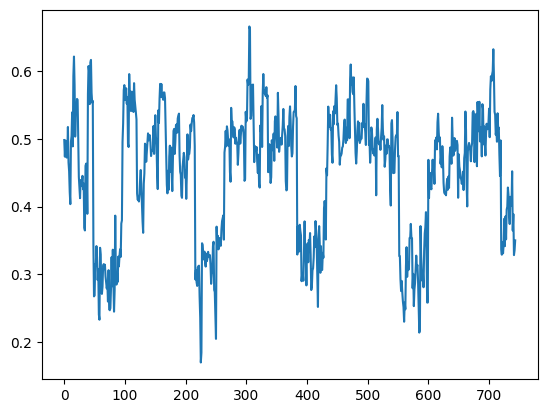

In [ ]:
df_test_original['customerES_89'].plot()

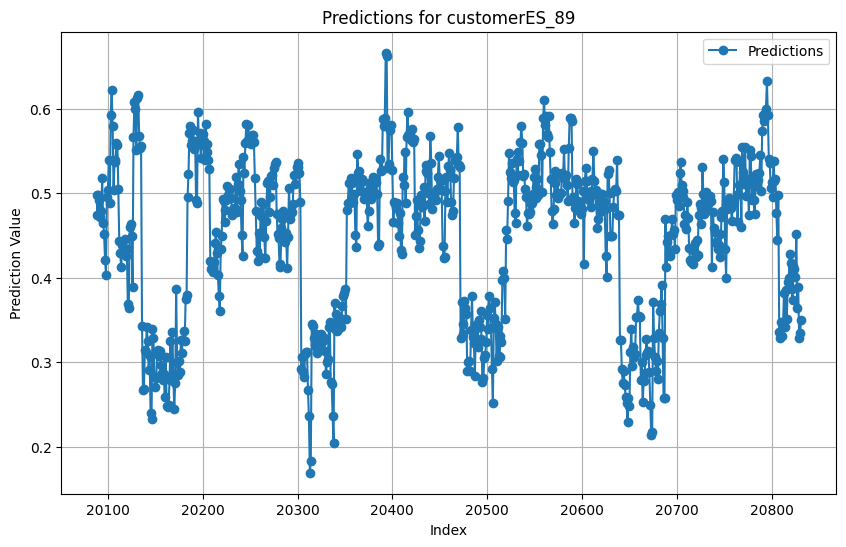

In [ ]:
# Filter predictions_df for the specific customer
customer_data = predictions_df[predictions_df['customer_id'] == 'customerES_89']

# Sort by any timestamp or index if needed
# If you have a timestamp/datetime column:
# customer_data = customer_data.sort_values('DATETIME')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(customer_data['prediction'], marker='o', linestyle='-', label='Predictions')
plt.title('Predictions for customerES_89')
plt.xlabel('Index')
plt.ylabel('Prediction Value')
plt.grid(True)
plt.legend()


In [ ]:
predictions_df.columns

Index(['prediction', 'customer_enc', 'customer_id'], dtype='object')

In [ ]:
# Save as CSV (most common)
df_test_original.to_csv('my_dataframe.csv', index=False)

# Save as Excel
df_test_original.to_excel('my_dataframe.xlsx', index=False)

# Save as pickle (preserves dtypes and is faster to read/write)
df_test_original.to_pickle('my_dataframe.pkl')

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("📉 July 2024 MAE:", mae)

In [ ]:
import matplotlib.pyplot as plt

# Reset index just in case
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)

# Plot full July
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual (y_test)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (y_pred)', color='red', alpha=0.6)
plt.title("📈 Actual vs Predicted Load — July 2024")
plt.xlabel("Timestep (Hourly)")
plt.ylabel("Load [MWh]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the best model from GridSearchCV
joblib.dump(grid.best_estimator_, "FINAL_xgboost_best_model.pkl")

print("✅ Model saved as: xgboost_best_model.pkl")




In [ ]:
print(best_model_final.get_params())